In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import losses
print('Tensorflow version: {}'.format(tf.__version__))


plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

gpu_device_name = tf.test.gpu_device_name()
print(gpu_device_name)
tf.test.is_gpu_available()

Tensorflow version: 2.0.0


2021-12-15 14:42:13.557979: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2021-12-15 14:42:13.596189: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400000000 Hz
2021-12-15 14:42:13.603040: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d65ed73870 executing computations on platform Host. Devices:
2021-12-15 14:42:13.603076: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2021-12-15 14:42:13.604447: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-15 14:42:15.405327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-SXM2-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:1b:00.0
2021-12-15 14:42:15.410836: I tensorflow/core/c

/device:GPU:0


2021-12-15 14:42:15.862342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Adding visible gpu devices: 0, 1, 2, 3, 4, 5, 6, 7
2021-12-15 14:42:15.869486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-12-15 14:42:15.869507: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      0 1 2 3 4 5 6 7 
2021-12-15 14:42:15.869517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1178] 0:   N Y Y Y Y Y Y Y 
2021-12-15 14:42:15.869524: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1178] 1:   Y N Y Y Y Y Y Y 
2021-12-15 14:42:15.869531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1178] 2:   Y Y N Y Y Y Y Y 
2021-12-15 14:42:15.869538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1178] 3:   Y Y Y N Y Y Y Y 
2021-12-15 14:42:15.869545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1178] 4:   Y Y Y Y N Y Y Y 
2021-12-15 14:42:15.869552: I tensorflow/core/common_runtime/gpu/gpu_devi

True

## Hyperparameters

In [2]:
# import tushare as ts
# pro = ts.pro_api('f198ddf6f6c8918413793b567bed6269e931f433abd746b26a3c2668')
# dd = pro.daily(ts_code='000001.SZ', start_data='20180701', end_data='20201119')
# dd.to_csv('pro001.csv')

In [3]:
batch_size = 128
seq_len = 10
d_k = 32
d_v = 32
n_heads = 32
ff_dim = 256

## TimeVector

In [4]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer

In [5]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_se1 = Conv1D(filters=self.ff_dim//2, kernel_size=1)
    self.ff_conv1D_se2 = Conv1D(filters=self.ff_dim, kernel_size=1,activation='sigmoid')
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    aa_layer = self.ff_conv1D_se1(ff_layer)
    aa_layer = self.ff_dropout(aa_layer)
    aa_layer = self.ff_conv1D_se2(aa_layer)
    aa_layer = self.ff_dropout(aa_layer)
    ff_layer = aa_layer+ff_layer
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

# Moving Average

## Moving Average - Load Tesla data again, to apply rolling window

In [6]:
def charge(number):
    if number>0.5:
        return 1
    else:
        return 0

In [7]:
# Tesla_path = '/home/changjiang_2/BDA/Stock-Prediction-Models-master/deep-learning/pro001.csv'
# df = pd.read_csv(Tesla_path, delimiter=',', usecols=['ts_code','Date','Open','High','Low','Close','pre_close','change','pct_chg','Volume','amount'])
# df['Volume'].replace(to_replace=0, method='ffill', inplace=True)
# df['pct_chg'].replace(to_replace=0, method='ffill', inplace=True)
# df['change'].replace(to_replace=0, method='ffill', inplace=True)
# df['amount'].replace(to_replace=0, method='ffill', inplace=True)
# lis = df['pct_chg']
# lising = []
# for l in lis:
#     new = charge(l)
#     lising.append(new)
# df.insert(11,'label',lising)
# df.sort_values('Date', inplace=True)
# df.drop(labels='ts_code',axis=1,inplace=True)
# # df.drop(labels='pre_close',axis=1,inplace=True)
# # df.drop(labels='pct_chg',axis=1,inplace=True)
# # df.drop(labels='change',axis=1,inplace=True)
# # df.drop(labels='amount',axis=1,inplace=True)
# # df[['Open', 'High', 'Low', 'Close','Volume']] = df[['Open', 'High', 'Low', 'Close','Volume']].rolling(10).mean()
# # df.drop('index')
# df.dropna(how='any', axis=0, inplace=True) 
# df.tail()

In [8]:
Tesla_path = '../dataset/TSLA.csv'

df = pd.read_csv(Tesla_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close','Adj Close','Volume'])
df.drop(labels='Adj Close',axis=1,inplace=True)
# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close','Volume']] = df[['Open', 'High', 'Low', 'Close','Volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head()

,Date,Open,High,Low,Close,Volume
9,2018-04-06,281.285999,290.033997,270.408002,282.077999,15257070.0
10,2018-04-09,280.197998,289.858997,269.283999,280.889998,15616560.0
11,2018-04-10,279.360998,289.809998,269.516000,280.942000,15878020.0
12,2018-04-11,279.034997,290.281000,271.764001,283.117000,15239110.0
13,2018-04-12,282.809000,293.808002,275.922000,286.746999,13899850.0


## Moving Average - Plot daily Tesla closing prices and volume

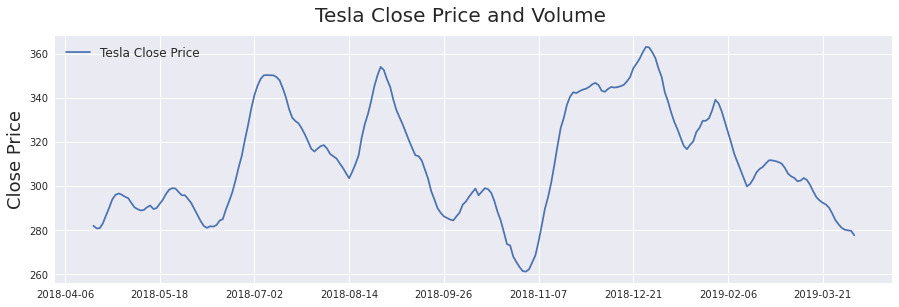

In [9]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Tesla Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='Tesla Close Price')
ax1.set_xticks(range(0, df.shape[0], 30))
ax1.set_xticklabels(df['Date'].loc[::30])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)


## Moving Average - Calculate normalized percentage change for all columns

In [10]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change()# Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

lis = df['Close']
lising = []
for l in lis:
    new = charge(l)
    lising.append(new)
df.insert(6,'label',lising)

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

# ###############################################################################
'''Normalize price columns'''
#
min_return = min(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df[(df.index < last_20pct)]['Volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['Volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['Volume'] = (df['Volume'] - min_volume) / (max_volume - min_volume)

###############################################################################
'''Create training, validation and test split'''

df_train = df[df.index<last_20pct] # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[df.index>=last_10pct]

# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
# print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

print(df_train.head())
print(df_val.head())
df_test.head()

Training data shape: (193, 6)
Test data shape: (24, 6)
        Open      High       Low     Close    Volume  label
10  0.352059  0.415661  0.346434  0.345364  0.422087      0
11  0.369219  0.424123  0.444201  0.431023  0.410054      0
12  0.404681  0.459079  0.589917  0.578246  0.309514      0
13  0.690920  0.664134  0.725498  0.677212  0.225447      0
14  0.751953  0.646174  0.764713  0.659849  0.280947      0
         Open      High       Low     Close    Volume  label
203  0.542791  0.463975  0.522648  0.430549  0.267649      0
204  0.410819  0.483317  0.483585  0.496151  0.374198      0
205  0.657718  0.641719  0.698359  0.639021  0.200820      0
206  0.658146  0.669456  0.707017  0.700951  0.286077      0
207  0.526281  0.479262  0.409735  0.338764  0.888924      0


,Open,High,Low,Close,Volume,label
227,0.387240,0.404150,0.450259,0.381988,0.284311,0
228,0.376747,0.327423,0.343205,0.309403,0.393274,0
229,0.315629,0.296642,0.267072,0.263188,0.503330,0
230,0.308470,0.313313,0.357263,0.345847,0.357374,0
231,0.370664,0.398722,0.417727,0.382428,0.404028,0


## Moving Average - Plot daily changes of close price and volume

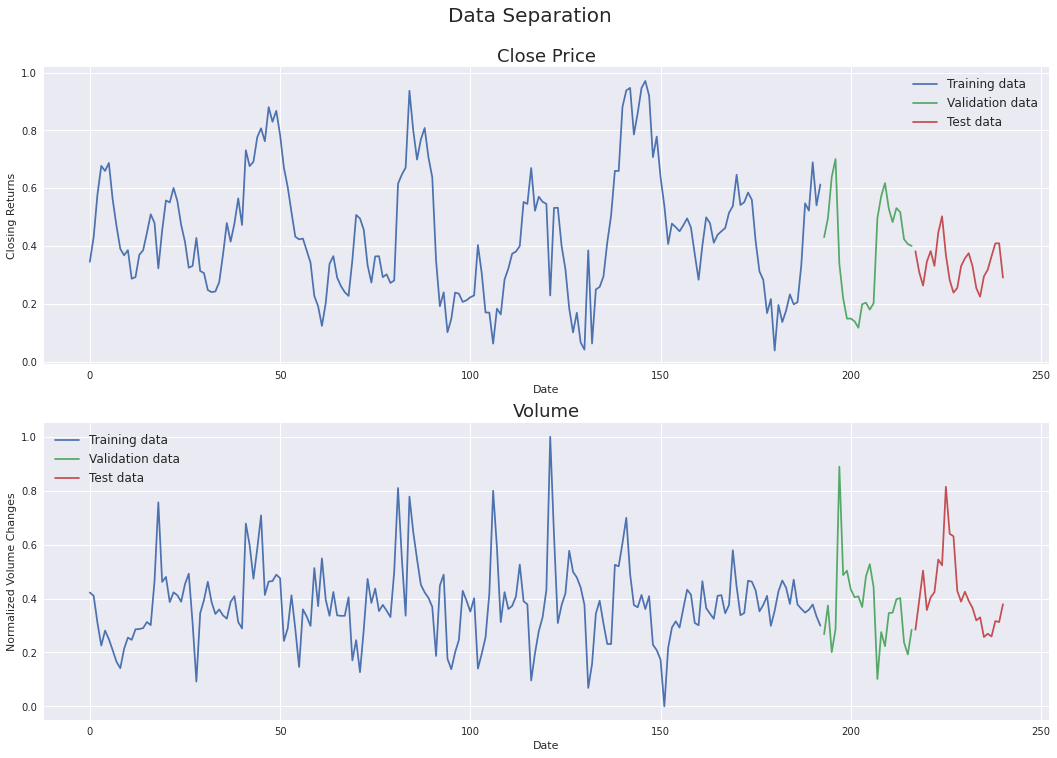

In [11]:
fig = plt.figure(figsize=(18,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Moving Average - Create chunks of training, validation, and test data

In [12]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[:,:5][i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 5][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

##############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[:,:5][i-seq_len:i])
    y_val.append(val_data[:, 5][i])
X_val, y_val = np.array(X_val), np.array(y_val)

##############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[:,:5][i-seq_len:i])
    y_test.append(test_data[:, 5][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (183, 10, 5) (183,)
Validation set shape (14, 10, 5) (14,)
Testing set shape (14, 10, 5) (14,)


In [13]:
y_test[0]

0.0

In [14]:
# # Training data
# X_train, y_train = [], []
# for i in range(seq_len, len(train_data)-5):
#   X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
#   y_train.append(train_data[:, 3][i+5]) #Value of 4th column (Close Price) of df-row 128+1
# X_train, y_train = np.array(X_train), np.array(y_train)

# ###############################################################################

# # # Validation data
# # X_val, y_val = [], []
# # for i in range(seq_len, len(val_data)):
# #     X_val.append(val_data[i-seq_len:i])
# #     y_val.append(val_data[:, 3][i])
# # X_val, y_val = np.array(X_val), np.array(y_val)

# ###############################################################################

# # Test data
# X_test, y_test = [], []
# for i in range(seq_len, len(test_data)-5):
#     X_test.append(test_data[i-seq_len])
#     y_test.append(test_data[:, 3][i+5])
# X_test, y_test = np.array(X_test), np.array(y_test)

# print(X_train.shape, y_train.shape)
# # print(X_val.shape, y_val.shape)

In [15]:
print(X_test.shape)

(14, 10, 5)


## Moving Average - Model

In [16]:
# X_train[0]

In [17]:
y_test.shape

(14,)

In [18]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  normall = LayerNormalization(axis=2)
  normal_first = LayerNormalization(axis=-1)
  # input_shape = (2,seq_len,7)
  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = BatchNormalization()(x,training=True)
  x = Concatenate(axis=-1)([in_seq, x])
  x = normal_first(x)
  x = normall(x)
  y = attn_layer1((x, x, x))
  x = x+y
  x = BatchNormalization()(x,training=True)
  x = normall(x)
  # x = sce2(x)
  # print(x.shape)
  y = attn_layer2((x, x, x))
  x = x+y
  x = normall(x)
  # x = sce2(x)
  x = attn_layer3((x, x, x))
  x = normall(x)
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = BatchNormalization()(x,training=True)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('./Transformer+TimeEmbedding_sz.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, 
                                              verbose=1)

# callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
#                                               monitor='mae', 
#                                               save_best_only=False, verbose=1)



2021-12-15 14:42:17.302094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-SXM2-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:1b:00.0
2021-12-15 14:42:17.305890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: Tesla V100-SXM2-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:1c:00.0
2021-12-15 14:42:17.308701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: Tesla V100-SXM2-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:60:00.0
2021-12-15 14:42:17.315207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: Tesla V100-SXM2-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.53
pciBusID: 0000:62:00.0
2021-12-15 14:42:17.320595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 4 with properties: 
name: Tesla V100-SXM2-32GB maj

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 5)]      0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 10, 2)        40          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 10, 2)        8           time2_vector[0][0]               
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 10, 7)        0           input_1[0][0]                    
                                                                 batch_normalization[0][0]    

In [19]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size, 
                    epochs=300,
                    callbacks=[callback],
                    validation_data=(X_val, y_val))



Train on 183 samples, validate on 14 samples
Epoch 1/300


2021-12-15 14:44:20.105430: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-12-15 14:44:21.516207: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


128/183 [===================>..........] - ETA: 51s - loss: 0.2500 - mae: 0.5000 - mape: 500000000.0000
Epoch 00001: val_loss improved from inf to 0.24524, saving model to ./Transformer+TimeEmbedding_sz.hdf5
183/183 [==============================] - 138s 753ms/sample - loss: 0.2493 - mae: 0.4993 - mape: 499297312.0000 - val_loss: 0.2452 - val_mae: 0.4952 - val_mape: 495221216.0000
Epoch 2/300
128/183 [===================>..........] - ETA: 1s - loss: 0.2453 - mae: 0.4953 - mape: 495261952.0000
Epoch 00002: val_loss improved from 0.24524 to 0.24043, saving model to ./Transformer+TimeEmbedding_sz.hdf5
183/183 [==============================] - 8s 43ms/sample - loss: 0.2446 - mae: 0.4945 - mape: 494520736.0000 - val_loss: 0.2404 - val_mae: 0.4903 - val_mape: 490338656.0000
Epoch 3/300
128/183 [===================>..........] - ETA: 1s - loss: 0.2405 - mae: 0.4904 - mape: 490449536.0000
Epoch 00003: val_loss improved from 0.24043 to 0.23556, saving model to ./Transformer+TimeEmbedding_sz.

In [20]:
model = tf.keras.models.load_model('./Transformer+TimeEmbedding_sz.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

 
Evaluation metrics
Training Data - Loss: 0.0005, MAE: 0.0229, MAPE: 22928068.0000
Validation Data - Loss: 0.0005, MAE: 0.0229, MAPE: 22928068.0000
Test Data - Loss: 0.0005, MAE: 0.0229, MAPE: 22928068.0000


In [21]:
# '''Display results'''

# fig = plt.figure(figsize=(15,20))
# st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
# st.set_y(0.92)

# #Plot training data results
# ax11 = fig.add_subplot(311)
# ax11.plot(train_data[:, 3], label='Tesla Closing Returns')
# ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Tesla Closing Returns')
# ax11.set_title("Training Data", fontsize=18)
# ax11.set_xlabel('Date')
# ax11.set_ylabel('Tesla Closing Returns')
# ax11.legend(loc="best", fontsize=12)

# #Plot validation data results
# ax21 = fig.add_subplot(312)
# ax21.plot(val_data[:, 3], label='Tesla Closing Returns')
# ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Tesla Closing Returns')
# ax21.set_title("Validation Data", fontsize=18)
# ax21.set_xlabel('Date')
# ax21.set_ylabel('Tesla Closing Returns')
# ax21.legend(loc="best", fontsize=12)

# #Plot test data results
# ax31 = fig.add_subplot(313)
# ax31.plot(test_data[:, 3], label='Tesla Closing Returns')
# ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Tesla Closing Returns')
# ax31.set_title("Test Data", fontsize=18)
# ax31.set_xlabel('Date')
# ax31.set_ylabel('Tesla Closing Returns')
# ax31.legend(loc="best", fontsize=12)

## Moving Average - Model metrics

In [22]:
test_pred[:]

array([[0.02291521],
       [0.02291116],
       [0.02291101],
       [0.02291974],
       [0.02292487],
       [0.0229196 ],
       [0.02291963],
       [0.02293861],
       [0.02294445],
       [0.02294695],
       [0.02294067],
       [0.02293575],
       [0.02293078],
       [0.02293451]], dtype=float32)

In [23]:
y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [32]:
# def calculate_accuracy(real, predict):
#     real = np.array(real) + 1
#     predict = np.array(predict) + 1
#     percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
#     return percentage * 100
# accuracies = [calculate_accuracy(df['Close'].iloc[-y_test.size:].values, r) for r in test_pred]
count = 0
for i in range(y_test.size):
    if charge(test_pred[i])==y_test[i]:
        count += 1
print("Accuracy is %.4f"%(count/len(y_test)))
# plt.figure(figsize = (15, 5))
# plt.plot(test_pred[:y_test.size], label = 'forecast')
# plt.plot(df['Close'].iloc[:y_test.size].values, label = 'true trend', c = 'black')
# plt.legend()
# plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
# plt.show()

Accuracy is 1.0000


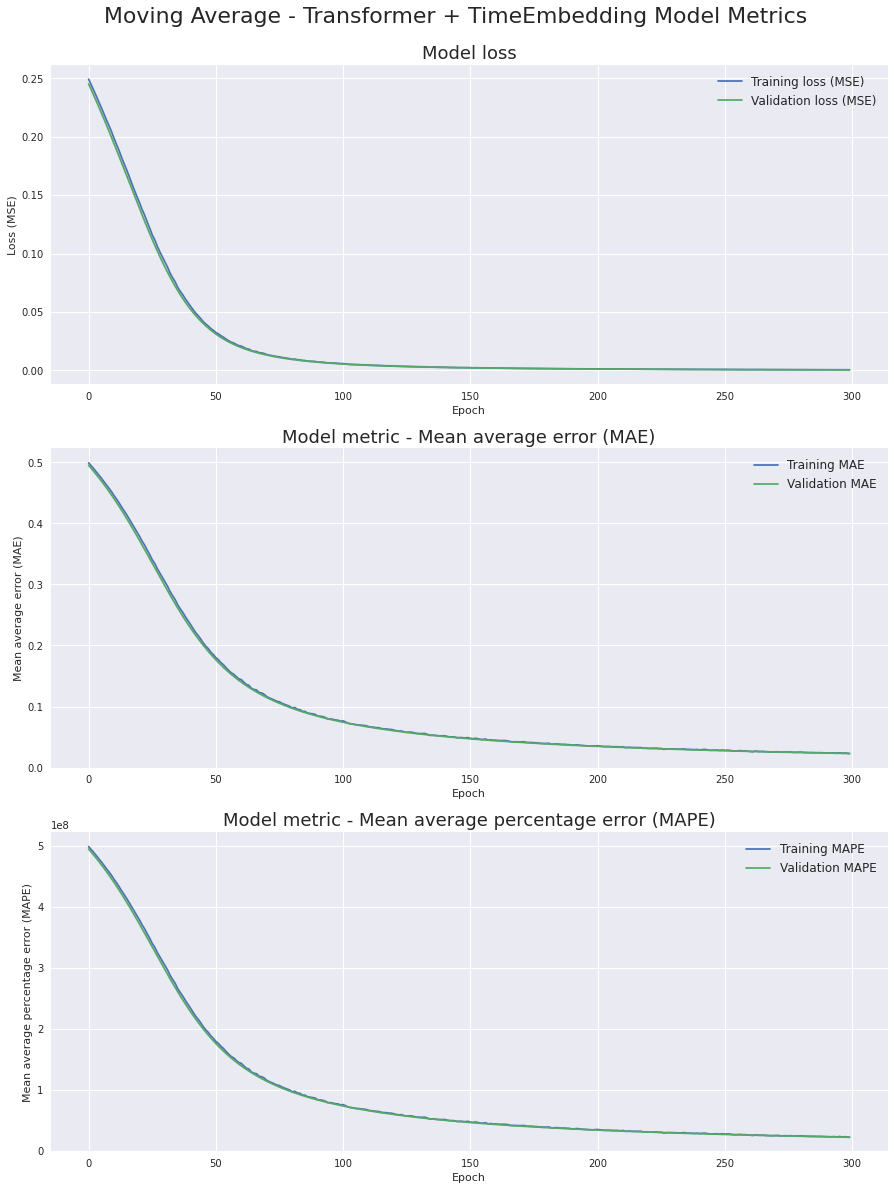

In [30]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)